In [1]:
import numpy as np
import pandas as pd
import time
import datetime
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import holidays
from datetime import date

import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
notebook_tic = time.time()

In [3]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.options.display.max_seq_items = 50

In [4]:
tic = time.time()

train = pd.read_csv('train.csv')
print("train loaded")
metadata = pd.read_csv('building_metadata.csv')
print("metadata loaded")
train = train.merge(metadata, on="building_id", how="left")
print("train and metadata merged")

weather = pd.read_csv('weather_train.csv')
print("weather loaded")
train = train.merge(weather, on=["site_id", "timestamp"], how="left")
print("train and weather merged")

toc = time.time()

print(toc - tic," seconds")

train loaded
metadata loaded
train and metadata merged
weather loaded
train and weather merged
17.619166374206543  seconds


In [5]:
#very large target causes trouble for rmsle
#restore this with np.expm1 in prediction
train['meter_reading'] = np.log1p(train['meter_reading']).astype(np.float32)

In [6]:
target_label = 'meter_reading'

# Expand features

In [7]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [8]:
tic = time.time()

feature_classes = train['primary_use'].unique()

#DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields primary_use

for j in range(len(feature_classes)):
    feature_class = feature_classes[j]
    train['primary_use'] = train['primary_use'].replace(feature_class, str(j))
train = train.astype({'primary_use': 'int32'})

toc = time.time()
print(toc-tic," seconds")

16.47582697868347  seconds


In [9]:
def expandFeatures(df):       
    df['year'] = pd.DatetimeIndex(df['timestamp']).year
    df['month'] = pd.DatetimeIndex(df['timestamp']).weekday
    df['day'] = pd.DatetimeIndex(df['timestamp']).day
    df['hour'] = pd.DatetimeIndex(df['timestamp']).hour
    df['weekday'] = pd.DatetimeIndex(df['timestamp']).weekday
    
    #--------------------------------------
    
    df['square_feet'] = np.log(df['square_feet'])
    df['year_built'] = np.uint8(train['year_built'].max() - df['year_built'])
    df['sea_level_pressure'] = np.uint8(df['sea_level_pressure'] - train['sea_level_pressure'].min())
    
    #--------------------------------------

    df = df.drop(columns = ["timestamp"])
    
    return df

In [10]:
tic = time.time()
train = expandFeatures(train)
toc = time.time()
print("Features expanded for train in ",toc-tic," seconds")

Features expanded for train in  24.05799150466919  seconds


# One hot encoding for categorical features

In [11]:
categorical_features = ['meter', 'primary_use', 'site_id'
                        #, 'building_id'
                       ]

In [12]:
for column in categorical_features:
    tic = time.time()
    print("processing ",column)
    unique_values = train[column].unique()
    one_hot = pd.get_dummies(unique_values, prefix=column)
    one_hot[column] = unique_values
 
    train = train.merge(one_hot, left_on = [column], right_on=[column], how="left")
    train = train.drop(columns = [column])
    toc = time.time()
    print("processed in ",toc-tic," seconds") #42 seconds

processing  meter
processed in  12.410517692565918  seconds
processing  primary_use
processed in  13.48523211479187  seconds
processing  site_id
processed in  17.28470468521118  seconds


In [13]:
train.head()

,building_id,meter_reading,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,weekday,meter_0,meter_1,meter_2,meter_3,primary_use_0,primary_use_1,primary_use_2,primary_use_3,...,primary_use_7,primary_use_8,primary_use_9,primary_use_10,primary_use_11,primary_use_12,primary_use_13,primary_use_14,primary_use_15,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,site_id_10,site_id_11,site_id_12,site_id_13,site_id_14,site_id_15
0,0,0.0,8.913550,9,NaN,25.0,6.0,20.0,NaN,51,0.0,0.0,2016,4,1,0,4,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.0,7.908387,13,NaN,25.0,6.0,20.0,NaN,51,0.0,0.0,2016,4,1,0,4,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0.0,8.589700,26,NaN,25.0,6.0,20.0,NaN,51,0.0,0.0,2016,4,1,0,4,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0.0,10.072597,15,NaN,25.0,6.0,20.0,NaN,51,0.0,0.0,2016,4,1,0,4,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0.0,11.666565,42,NaN,25.0,6.0,20.0,NaN,51,0.0,0.0,2016,4,1,0,4,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
train.shape

(20216100, 53)

In [15]:
feature_names = []

for i in train.columns:
    if i != target_label:
        feature_names.append(i)

# Train Test and Validation Split

In [16]:
tic = time.time()
x_train, x_test = train_test_split(train, test_size=0.30, random_state=17)
x_test, x_validation = train_test_split(x_test, test_size=0.50, random_state=17)
toc = time.time()

print(toc - tic," seconds") #18.314871549606323  seconds

18.314871549606323  seconds


In [17]:
x_train.shape

(14151270, 53)

In [18]:
x_test.shape

(3032415, 53)

In [19]:
x_validation.shape

(3032415, 53)

# XGBoost

In [20]:
import xgboost

In [21]:
model = xgboost.XGBRegressor(
    n_estimators=250  
    , max_depth=10
    , learning_rate=0.01
    , seed = 4241
    , nthread = 5
) 

In [22]:
eval_set = [
    (x_validation.drop(columns=[target_label]), x_validation[target_label])
    #,(x_test.drop(columns=[target_label]), x_test[target_label])
]

In [23]:
tic = time.time()

model.fit(x_train.drop(columns=[target_label]), x_train[target_label]
         , eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=50, verbose=True)

toc = time.time()
print(toc - tic," seconds")

/workspaces/sefik/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/workspaces/sefik/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:55:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:55:59] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:4.19391
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4.15752
[2]	validation_0-rmse:4.12147
[3]	validation_0-rmse:4.08583
[4]	validation_0-rmse:4.05059
[5]	validation_0-rmse:4.01576
[6]	validation_0-rmse:3.98133
[7]	validation_0-rmse:3.94729
[8]	validation_0-rmse:3.91359
[9]	validation_0-rmse:3.88029
[10]	validation_0-rmse:3.84735
[11]	validation_0-rmse:3.81483
[12]	validation_0-rmse:3.78271
[13]	validation_0-rmse:3.75096
[14]	validation_0-rmse:3.7195
[15]	validation_0-rmse:3.68843
[16]	validation_0-rmse:3.65774
[17]	validation_0-rmse:3.62739
[18]	validation_0-rmse:3.59734
[19]	validation_

[248]	validation_0-rmse:1.33038
[249]	validation_0-rmse:1.32893
16389.913560152054  seconds


In [24]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=5, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=4241,
       silent=None, subsample=1, verbosity=1)

# Feature Importance

In [25]:
from xgboost import plot_importance

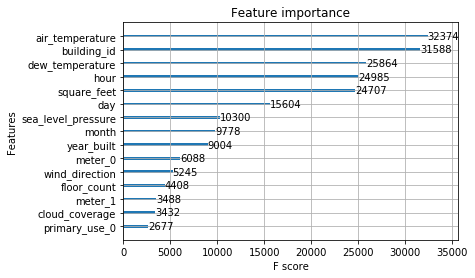

In [36]:
plot_importance(model, max_num_features=15, show_values=True)

# Prediction

In [27]:
predictions = model.predict(x_test.drop(columns=[target_label]))

In [28]:
actuals = x_test[target_label]

# Performance

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [31]:
from math import sqrt

mae = mean_absolute_error(actuals.values, predictions)
mse = mean_squared_error(actuals.values, predictions)
rmse = sqrt(mse)
#msle = mean_squared_log_error(actuals.values, predictions)
#rmsle = sqrt(msle)

print("mae: ", mae)
print("mse: ", mse)
#print("rmse:", rmse)
#print("rmsle: ", rmsle)

mae:  0.97053593
mse:  1.7646412


# Print Predictions

In [32]:
denormalized_predictions = np.expm1(predictions)

In [33]:
pd.DataFrame(denormalized_predictions, columns=['prediction']).tail()

,prediction
3032410,8.125707
3032411,3.377987
3032412,82.755051
3032413,40.304890
3032414,9.669287


In [34]:
notebook_toc = time.time()

In [35]:
print("notebook completed in ",notebook_toc-notebook_tic," seconds")

notebook completed in  16932.74189543724  seconds
